# Examen Final (2:23 P.M)

In [1]:
!pip install arch statsmodels --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 9.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from google.colab import files
import statsmodels.api as sm
from arch import arch_model
from statsmodels.tsa.stattools import adfuller, kpss, zivot_andrews
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

## Reusable functions
# Function for unit root tests with interpretation
def unit_root_tests(series, name):
    print(f"\nUnit Root Tests for {name}:")

    # ADF Test
    adf_result = adfuller(series)
    print("ADF Test:")
    print(f'ADF Statistic: {adf_result[0]:.4f}')
    print(f'p-value: {adf_result[1]:.4f}')
    print(f'Critical Values: {adf_result[4]}')
    print("INTERPRETATION:")
    if adf_result[1] < 0.05:
        print(f"  - p-value < 0.05: Reject null hypothesis - {name} is stationary")
    else:
        print(f"  - p-value >= 0.05: Fail to reject null - {name} may be non-stationary")

    # KPSS Test
    kpss_result = kpss(series)
    print("\nKPSS Test:")
    print(f'KPSS Statistic: {kpss_result[0]:.4f}')
    print(f'p-value: {kpss_result[1]:.4f}')
    print(f'Critical Values: {kpss_result[3]}')
    print("INTERPRETATION:")
    if kpss_result[1] < 0.05:
        print(f"  - p-value < 0.05: Reject null hypothesis - {name} is non-stationary")
    else:
        print(f"  - p-value >= 0.05: Fail to reject null - {name} may be stationary")

# Function to find best ARIMA model with interpretation
def find_best_arima(series, name, max_p=3, max_d=2, max_q=3):
    best_aic = float('inf')
    best_order = None

    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                try:
                    model = ARIMA(series, order=(p, d, q))
                    results = model.fit()
                    if results.aic < best_aic:
                        best_aic = results.aic
                        best_order = (p, d, q)
                except:
                    continue

    print(f"\nBest ARIMA model for {name}:")
    print(f"Order: {best_order}")
    print(f"AIC: {best_aic:.2f}")
    print("INTERPRETATION:")
    print(f"  - p={best_order[0]}: {best_order[0]} autoregressive term(s)")
    print(f"  - d={best_order[1]}: {best_order[1]} difference(s) needed for stationarity")
    print(f"  - q={best_order[2]}: {best_order[2]} moving average term(s)")
    return best_order

# Plot the series
def plot(series, name):
  plt.figure(figsize=(12,6))
  plt.plot(series, label=name)
  plt.title(f'{name}')
  plt.legend()
  plt.show()

# Plot detailed forecast with confidence intervals and interpretation
def plot_forecast(model, series, name, steps=30):
    forecast_obj = model.get_forecast(steps=steps)
    forecast = model.forecast(steps=steps)
    forecast = forecast_obj.predicted_mean
    conf_int = forecast_obj.conf_int()

    forecast_index = range(len(series), len(series) + steps)

    plt.figure(figsize=(12,6))
    plt.plot(series, label=f'{name} Historical')
    plt.plot(forecast_index, forecast, label='Forecast', color='red')
    plt.fill_between(forecast_index,
                    conf_int.iloc[:, 0],
                    conf_int.iloc[:, 1],
                    color='pink',
                    alpha=0.3,
                    label='95% Confidence Interval')
    plt.title(f'{name} Price Forecast')
    plt.legend()
    plt.show()

    # Print forecast values
    print(f"\n{name} Forecast Values (next 5 periods):")
    print(forecast[:5])

    # Forecast interpretation
    last_value = series.iloc[-1]
    mean_forecast = forecast.mean()
    print(f"\nForecast Interpretation for {name}:")
    print(f"Last observed value: {last_value:.2f}")
    print(f"Average forecast value: {mean_forecast:.2f}")
    print(f"Forecast change: {mean_forecast - last_value:.2f}")
    if mean_forecast > last_value:
        print("Trend: Upward forecast trend")
    elif mean_forecast < last_value:
        print("Trend: Downward forecast trend")
    else:
        print("Trend: Flat forecast trend")
    print(f"95% CI range at period {steps}: [{conf_int.iloc[-1, 0]:.2f}, {conf_int.iloc[-1, 1]:.2f}]")
    print("Interpretation: The wider the confidence interval, the less certain the forecast")

# Function to plot correlograms with interpretation
def plot_correlograms(series, name, lags=30):
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plot_acf(series, lags=lags, ax=plt.gca())
    plt.title(f'ACF for {name}')
    plt.subplot(2, 1, 2)
    plot_pacf(series, lags=lags, ax=plt.gca())
    plt.title(f'PACF for {name}')
    plt.tight_layout()
    plt.show()
    print(f"\nCorrelogram Interpretation for {name}:")
    print("  - ACF: Shows total correlation at each lag, including indirect effects")
    print("  - PACF: Shows direct correlation at each lag, controlling for earlier lags")
    print("  - Significant spikes outside the blue confidence interval suggest strong correlations")
    print("  - ACF decay pattern indicates potential ARIMA model orders")
    print("  - PACF cutoff suggests AR order, while ACF cutoff suggests MA order")

In [12]:
data_df = pd.read_excel("./Datos Problema 18.xlsx")
data_df

,YEAR,GDP,PDI,PCE,PROFITS,DIVIDENDS,LOG PDI
0,1970.1,2872.8,1990.6,1800.5,44.7,24.5,7.596191
1,1970.2,2860.3,2020.1,1807.5,44.4,23.9,7.610902
2,1970.3,2896.6,2045.3,1824.7,44.9,23.3,7.623300
3,1970.4,2873.7,2045.2,1821.2,42.1,23.1,7.623251
4,1971.1,2942.9,2073.9,1849.9,48.8,23.8,7.637186
...,...,...,...,...,...,...,...
83,1990.4,4855.1,3529.5,3251.8,199.0,136.2,8.168911
84,1991.1,4824.0,3514.8,3241.1,189.7,137.8,8.164738
85,1991.2,4840.7,3537.4,3252.4,182.7,136.7,8.171147
86,1991.3,4862.7,3539.9,3271.2,189.6,138.1,8.171854


In [13]:
dip_df = data_df["LOG PDI"]
dip_df

,LOG PDI
0,7.596191
1,7.610902
2,7.623300
3,7.623251
4,7.637186
...,...
83,8.168911
84,8.164738
85,8.171147
86,8.171854


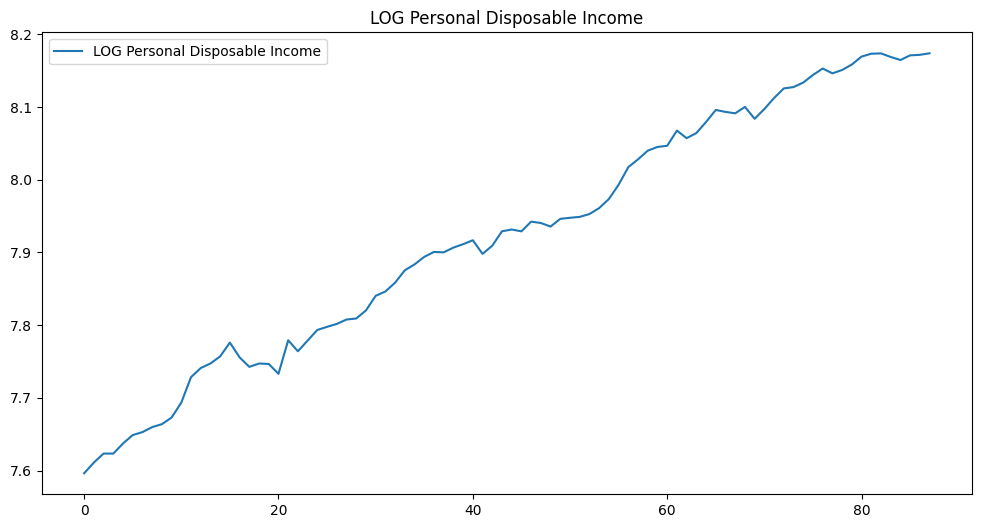

In [14]:
plot(dip_df, "LOG Personal Disposable Income")

In [15]:
unit_root_tests(dip_df, "LOG Personal Disposable Income")


Unit Root Tests for LOG Personal Disposable Income:
ADF Test:
ADF Statistic: -1.4407
p-value: 0.5626
Critical Values: {'1%': np.float64(-3.512738056978279), '5%': np.float64(-2.8974898650628984), '10%': np.float64(-2.585948732897085)}
INTERPRETATION:
  - p-value >= 0.05: Fail to reject null - LOG Personal Disposable Income may be non-stationary

KPSS Test:
KPSS Statistic: 1.5566
p-value: 0.0100
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
INTERPRETATION:
  - p-value < 0.05: Reject null hypothesis - LOG Personal Disposable Income is non-stationary


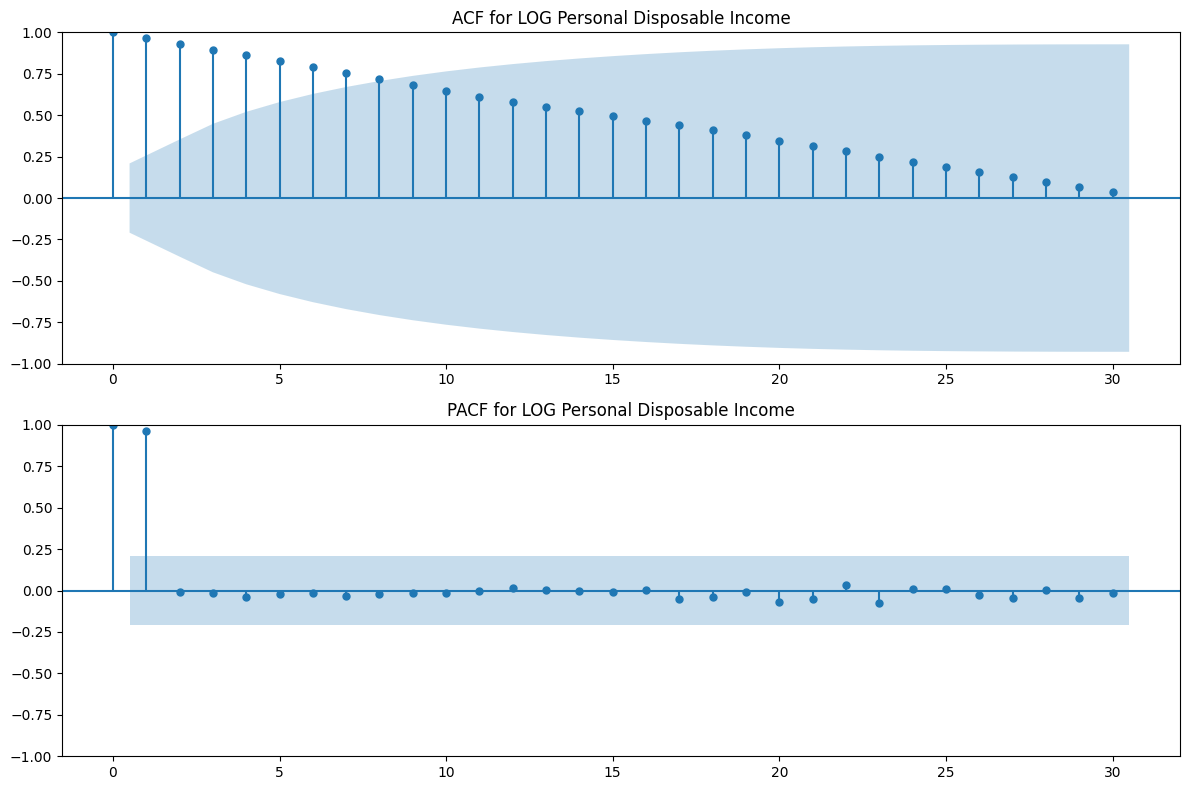


Correlogram Interpretation for LOG Personal Disposable Income:
  - ACF: Shows total correlation at each lag, including indirect effects
  - PACF: Shows direct correlation at each lag, controlling for earlier lags
  - Significant spikes outside the blue confidence interval suggest strong correlations
  - ACF decay pattern indicates potential ARIMA model orders
  - PACF cutoff suggests AR order, while ACF cutoff suggests MA order


In [16]:
plot_correlograms(dip_df, "LOG Personal Disposable Income")

In [17]:
dip_order = find_best_arima(dip_df, "LOG Personal Disposable Income")

dip_arima_model = ARIMA(dip_df, order=dip_order).fit()
print(dip_arima_model.summary())


Best ARIMA model for LOG Personal Disposable Income:
Order: (1, 1, 1)
AIC: -535.21
INTERPRETATION:
  - p=1: 1 autoregressive term(s)
  - d=1: 1 difference(s) needed for stationarity
  - q=1: 1 moving average term(s)
                               SARIMAX Results                                
Dep. Variable:                LOG PDI   No. Observations:                   88
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 270.603
Date:                Sun, 02 Nov 2025   AIC                           -535.206
Time:                        20:20:25   BIC                           -527.808
Sample:                             0   HQIC                          -532.227
                                 - 88                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

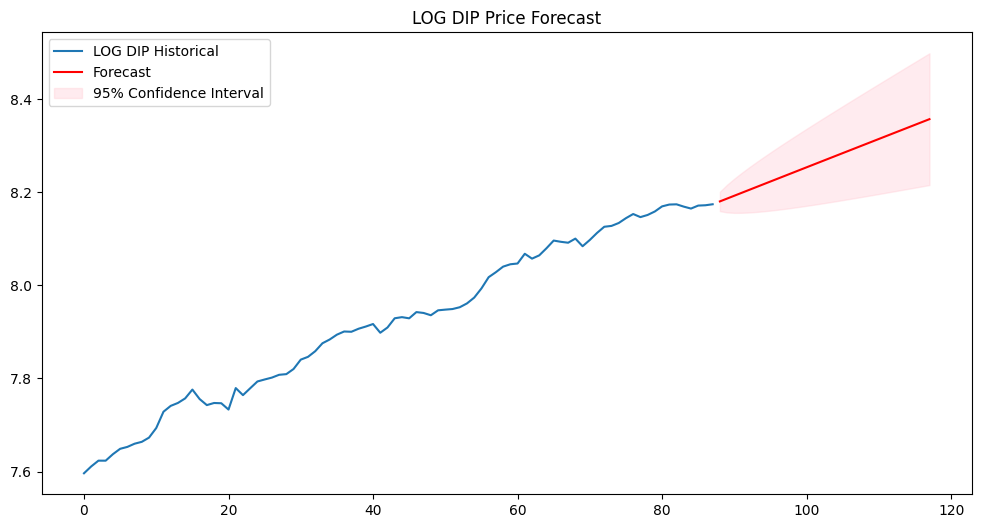


LOG DIP Forecast Values (next 5 periods):
88    8.180114
89    8.186228
90    8.192341
91    8.198451
92    8.204561
Name: predicted_mean, dtype: float64

Forecast Interpretation for LOG DIP:
Last observed value: 8.17
Average forecast value: 8.27
Forecast change: 0.09
Trend: Upward forecast trend
95% CI range at period 30: [8.22, 8.50]
Interpretation: The wider the confidence interval, the less certain the forecast


In [10]:
forecast_steps = 30
last_index = len(dip_df) - 1
forecast_index = range(last_index + 1, last_index + 1 + forecast_steps)

plot_forecast(dip_arima_model, dip_df, "LOG DIP")

## Pasos para generar un modelo ARIMA
Para el presente ejercicio se consideraron dos alternativas:
1. Utilizar directamente el lograitmo natural de las observaciones del PDI.
2. Trabajar con el porcentaje de cambio entre observaciones consecutivas, aplicando propiedades logaritmicas.

Aunque ambas opciones podrían conducir a conclusiones similares, la interpretación y el manejo estadístico de los datos varían debido a las propiedades intrínsecas de cada enfoque. Para este análisis se decidió continuar con la primera opción, es decir, trabajar directamente con el lograitmo natural del PDI.

### Evaluar de la estacionariedad mediante pruebas de raíz unitaria
Se aplicaron las pruebas de raíz unitaria ADF y KPSS para verificar la estacionariedad de la serie de tiempo.
1. La prueba ADF no proporcionó evidencia estadística suficiente para rechazar la hipótesis nula, lo que indica la presencia de una raíz unitaria, y por ende, que la serie no es estacionaria.
2. La prueba KPSS rechazó la hipótesis nula, sugiriendo que la serie no es estacionaria alrededor de una tendencia determinista.

Ambos resultados apuntan a la misma conclusión: la serie original no es estacionaria.

### Análisis de correlogramas para confirmar la estacionariedad
Los niveles de significancia en el correlograma ACF decaen lentamente, lo que sugiere que la serie de tiempo no es estacionaria. En cambio, el correlograma PACF presenta una caída abrupta después del rezago 1, lo que indica que un modelo autorregresivo de orden 1 AR(1), podría capturar parte de la dinámica de la serie.

Es importante destacar que los correlogramas son una herramienta exploratoria inicial para identificar posibles modelos, pero la selección definitiva debe basarse en un análisis más amplio, que incluya inspección visual, diagnóstico de residuos y criterios de información.

### Selección de parámetros del modelo ARIMA
Para determinar el modelo ARIMA óptimo se implementó un algoritmo de fuerza bruta que minimiza el criterio AIC. El modelo que mejor ajustó los datos fue un ARIMA (1, 1, 1), donde p = 1 representa la cantidad de términos autorregresivos, d = 1 el orden de diferenciación requerido para alcanzar estacionariedad, y q = 1 la cantidad de términos de error rezagados (medias móviles).

### Estimación y validación del modelo ARIMA
Los resultados indican que tanto los términos autorregresivos como de medias móviles son estadísticamente significativos, al igual que la varianza del término de error. La prueba de Ljung-Box mostró un p-value mayor que α = 0.05, lo que indica independencia de los residuos, cumpliendo así un supuesto clave del modelo. Sin embargo, la prueba Jarque-Bera mostró que los residuos no siguen una distribución normal, lo cual limita la confiabilidad de los intervalos de predicción.

### Predecir y graficar los resultados.
Las predicciones generadas por el modelo muestran una tendencia creciente, consistente con las observaciones recientes. Es importante tener en cuenta que los valores pronosticados corresponden al logaritmo natural del PDI, por lo que para obtener las predicciones en la escala original es necesario aplicar la transformación inversa (exponencial).

Los intervalos de confianza deben mantenerse lo más estrechos posible, ya que intervalos demasiado amplios disminuyen la confianza en las estimaciones.